In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp1d

from agent_distribution import AgentDistribution
from utils import compute_continuity_noise, compute_contraction_noise, compute_score_bounds

In [83]:
def fixed_point_interpolation_true_distribution(agent_dist, sigma, q, plot=False, savefig=None):
    """Method that returns a function that maps model parameters to the fixed point it induces.
    
    The function is estimated by doing a linear interpolation of the fixed points from theta 
    (a 1-dimensional parametrization of beta). theta -> beta = [cos (theta),  sin(theta)]
    The function maps theta -> s_beta.
    
    Keyword args:
    agent_dist -- AgentDistribution
    sigma -- standard deviation of the noise distribution (float)
    q -- quantile (float)
    plot -- optional plotting argument
    savefig -- path to save figure
    
    Returns:
    f -- interp1d object that maps theta to s_beta
    """
    dim = agent_dist.d
    assert dim==2, "Method does not work for dimension {}".format(dim)
    
    thetas = np.linspace(-np.pi, np.pi, 50)
    fixed_points = []
    betas = []
    
    #compute beta and fixed point for each theta
    print("Computing fixed points...")
    for theta in thetas:
        beta = np.array([np.cos(theta), np.sin(theta)]).reshape(dim, 1)
        fp = agent_dist.quantile_fixed_point_true_distribution(beta, sigma, q, plot=True)
        fixed_points.append(fp)
        betas.append(beta)
        
    f = interp1d(thetas, fixed_points, kind="cubic")
    
    if plot:
        plt.plot(thetas, fixed_points, label="actual")
        plt.plot(thetas, f(thetas), label="interpolation")
        plt.xlabel("Thetas (corresponds to different Beta)")
        plt.ylabel("s_beta")
        plt.title("Location of Fixed Points: s_beta vs. beta")
        plt.legend()
        if savefig is not None:
            plt.savefig(savefig)
        plt.show()
        plt.close()
        
    return f

def empirical_policy_loss(agent_dist, beta, s, sigma, q, true_beta=None):
    """Method that returns the empirical policy loss incurred given an agent distribution and model and threshold.
    Assumes that there is an model true_beta when applied to the agents' hidden eta features 
    optimally selects the top agents.
    
    Keyword args:
    agent_dist -- AgentDistribution
    beta -- model parameters (N, 1) array
    s -- threshold (float)
    q -- quantile
    sigma -- standard deviation of the noise (float)
    true_beta -- (N, 1) array
    
    Returns:
    loss -- empirical policy loss
    """
    if true_beta is None:
        true_beta = np.zeros(beta.shape)
        true_beta[0] = 1.

    true_agent_types = agent_dist.n_agent_types
    etas = agent_dist.get_etas()
    true_scores = np.array([np.matmul(true_beta.T, eta).item() for eta in etas]).reshape(agent_dist.n, 1)
    
    br_dist = agent_dist.best_response_score_distribution(beta, s, sigma)
    n_br = br_dist[agent_dist.n_agent_types]
    curr_bounds = compute_score_bounds(beta)
    
    noisy_scores = norm.rvs(loc=0.0, scale=sigma, size=agent_dist.n)
    noisy_scores += n_br
    noisy_scores = np.clip(noisy_scores, a_min=curr_bounds[0], a_max=curr_bounds[1]).reshape(agent_dist.n, 1)
    x = np.quantile(noisy_scores, q)
    loss = -np.mean(true_scores * (noisy_scores >= x))
    return loss

def optimal_beta_empirical_policy_loss(agent_dist, sigma, q, f, true_beta=None, plot=False, savefig=None):
    """Method returns the model parameters that minimize the empirical policy loss.
    
    Keyword args:
    agent_dist -- AgentDistribution
    sigma -- standard deviation of noise distribution
    f -- function that maps arctan(beta[1]/beta[0]) -> s_beta (fixed point)
    true_beta -- optional ideal model
    plot -- optional plotting 
    savefig -- path to save figure
    
    Returns:
    min_loss -- minimum loss (float)
    opt_beta -- beta that minimizes the loss (2, 1) array
    opt_s_beta -- optimal threshold (float)
    """
    dim = agent_dist.d
    assert dim==2, "Method does not work for dimension {}".format(dim)
        
    thetas = np.linspace(-np.pi, np.pi, 50)
    losses = []
    for theta in thetas:
        beta = np.array([np.cos(theta), np.sin(theta)]).reshape(2, 1)
        loss = empirical_policy_loss(agent_dist, beta, f(theta), sigma, q, true_beta=true_beta)
        losses.append(loss)
        
    idx = np.argmin(losses)
    min_loss = losses[idx]
    opt_beta = np.array([np.cos(thetas[idx]), np.sin(thetas[idx])]).reshape(2, 1)
    opt_s_beta = f(thetas[idx])
    if plot:
        plt.plot(thetas, losses)
        plt.xlabel("Theta (Represents Beta)")
        plt.ylabel("Empirical Loss")
        plt.title("Empirical Loss Incurred at Different Beta")
        if savefig:
            plt.savefig(savefig)
        
    return min_loss, opt_beta, opt_s_beta

def expected_policy_loss(agent_dist, theta, sigma, f, true_beta=None):
    """Method that computes the expected policy loss of deploying a particular model.
    
    Keyword args:
    agent_dist -- AgentDistribution
    beta -- model parameters
    sigma -- standard deviation of noise distribution
    f -- function that maps arctan(beta[1]/beta[0]) -> s_beta (fixed point)
    true_beta -- optional ideal model
    
    
    Returns:
    loss -- expected policy loss at beta
    """
    dim = agent_dist.d
    assert dim==2, "Method does not work for dimension {}".format(dim)
    
    beta = np.array([np.cos(theta), np.sin(theta)]).reshape(2, 1)
    if true_beta is None:
        true_beta = np.zeros(beta.shape)
        true_beta[0] = 1.
    
    bounds = compute_score_bounds(beta)
    s = np.clip(f(theta), a_min=bounds[0], a_max = bounds[1])
    true_scores = np.array([np.matmul(true_beta.T, agent.eta).item() for agent in agent_dist.agents]) 
    br_dist = agent_dist.best_response_score_distribution(beta, s, sigma)
    z = s - br_dist
    
    prob = 1- norm.cdf(x=z, loc=0., scale=sigma)
    product = -true_scores * prob * agent_dist.prop
        
    return np.sum(product).item() #np.sum(product).item()


def optimal_beta_expected_policy_loss(agent_dist, sigma, f, true_beta=None, plot=False, savefig=None):
    """Method returns the model parameters that minimize the expected policy loss.
    
    Keyword args:
    agent_dist -- AgentDistribution
    sigma -- standard deviation of noise distribution
    f -- function that maps arctan(beta[1]/beta[0]) -> s_beta (fixed point)
    true_beta -- optional ideal model
    plot -- optional plotting 
    savefig -- path to save figure
    """
    dim = agent_dist.d
    assert dim==2, "Method does not work for dimension {}".format(dim)
        
    thetas = np.linspace(-np.pi, np.pi, 50)
    losses = []
    for theta in thetas:
        loss = expected_policy_loss(agent_dist, theta, sigma, f, true_beta)
        losses.append(loss)
        
    idx = np.argmin(losses)
    min_loss = losses[idx]
    opt_beta = np.array([np.cos(thetas[idx]), np.sin(thetas[idx])]).reshape(2, 1)
    opt_s_beta = f(thetas[idx])
    if plot:
        plt.plot(thetas, losses)
        plt.xlabel("Theta (Represents Beta)")
        plt.ylabel("Expected Loss")
        plt.title("Expected Loss Incurred at Different Beta")
        if savefig:
            plt.savefig(savefig)
        
    return min_loss, opt_beta, opt_s_beta, thetas, losses
    
    
    

In [71]:
agent_dist = AgentDistribution(n=10000, n_types=20)
sigma_continuity = compute_continuity_noise(agent_dist)
sigma_contraction = compute_contraction_noise(agent_dist)
q = 0.7


Computing fixed points...


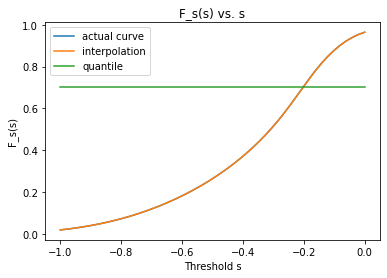

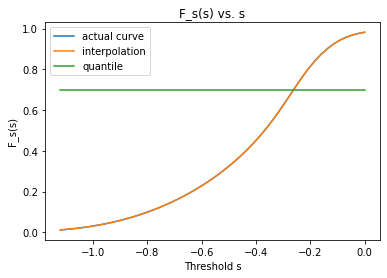

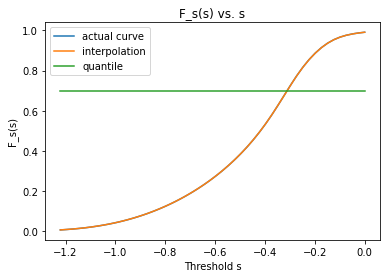

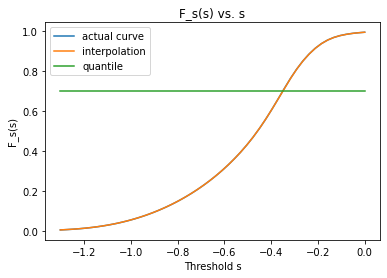

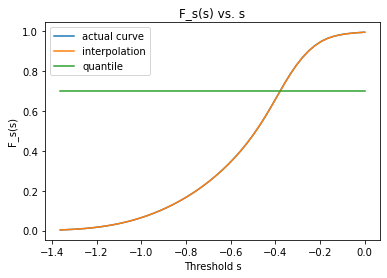

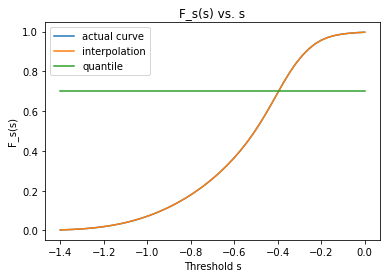

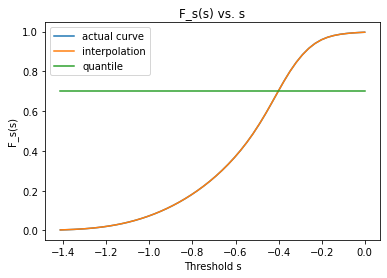

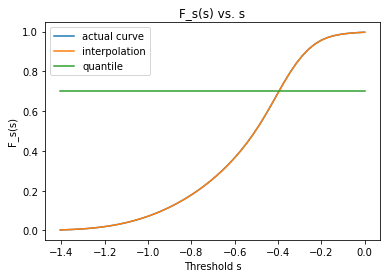

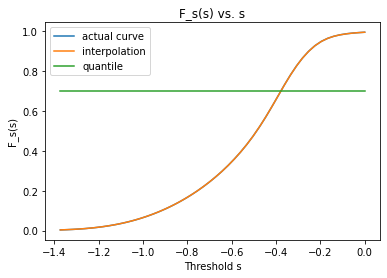

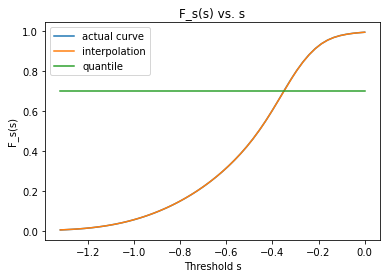

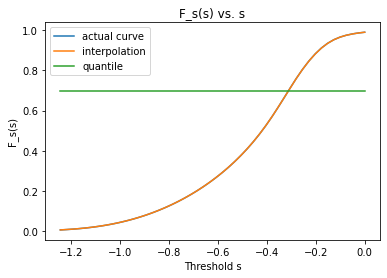

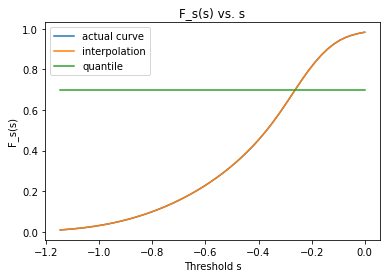

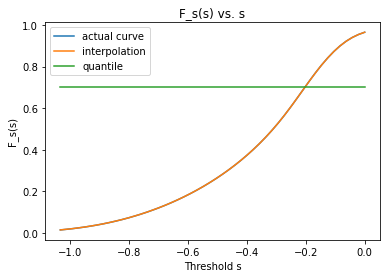

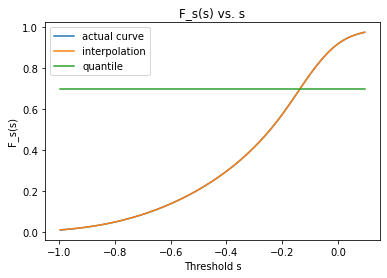

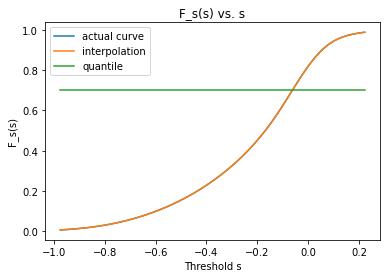

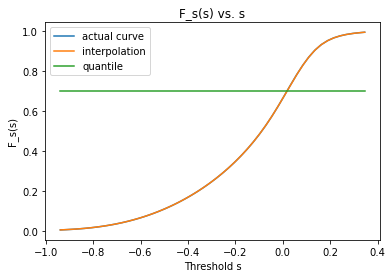

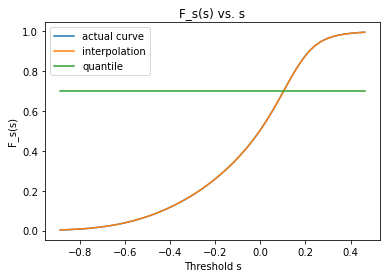

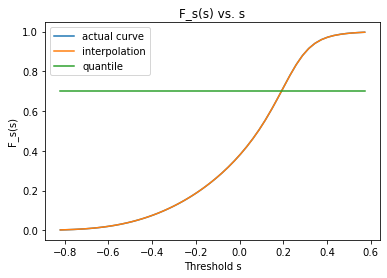

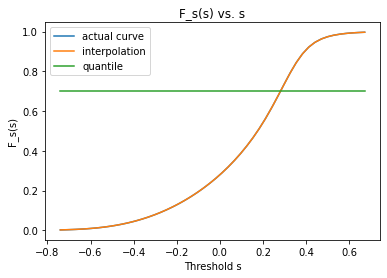

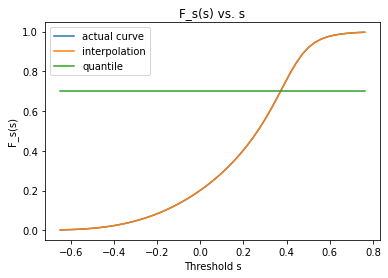

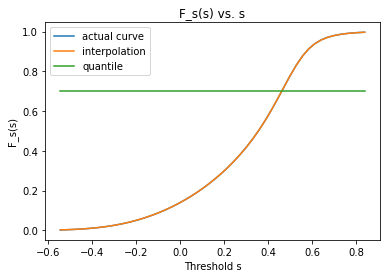

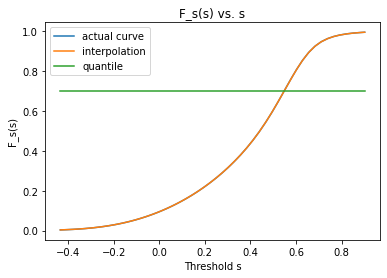

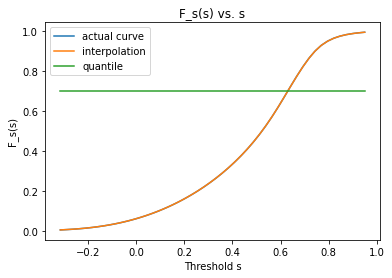

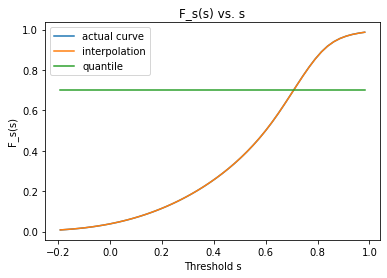

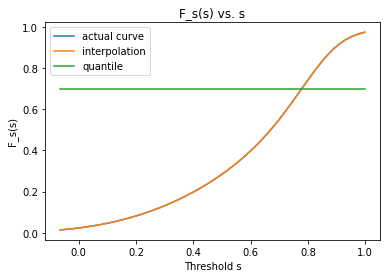

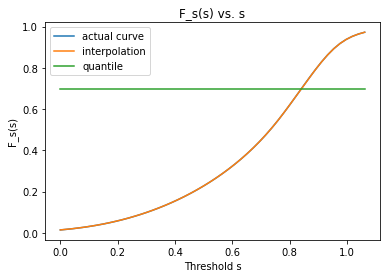

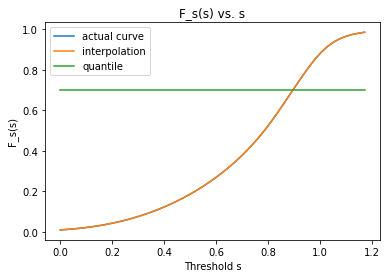

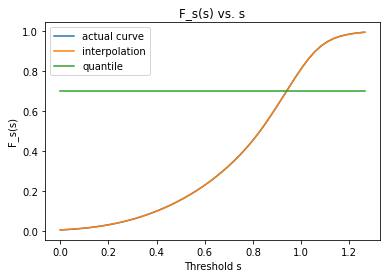

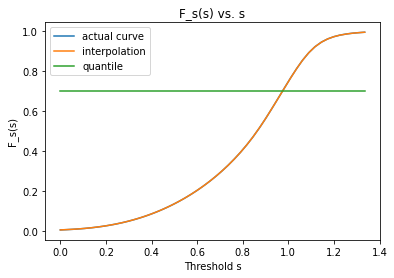

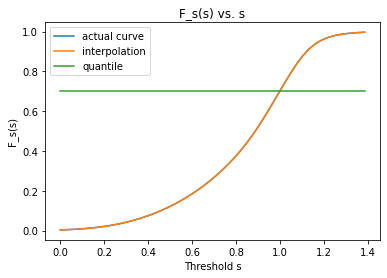

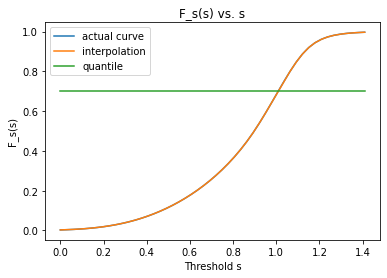

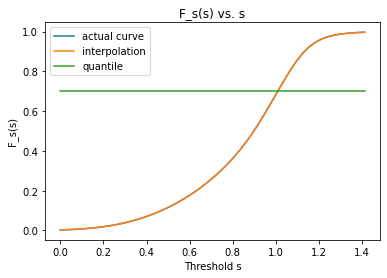

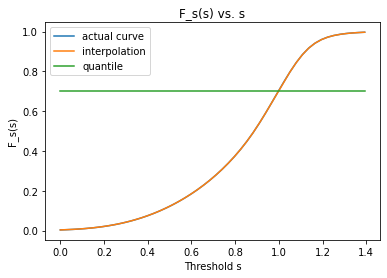

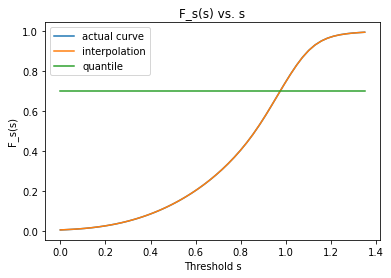

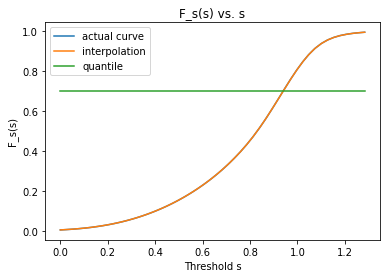

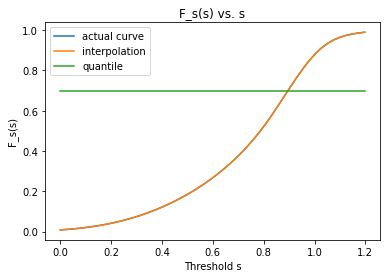

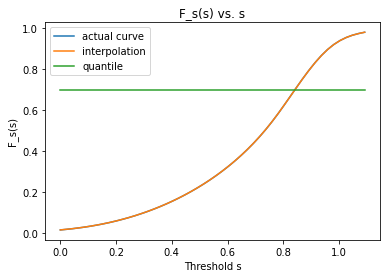

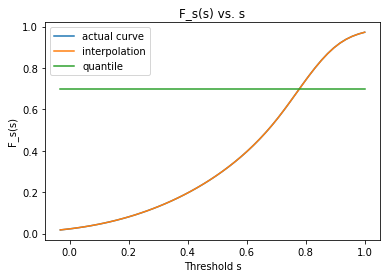

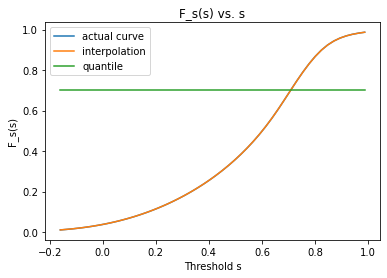

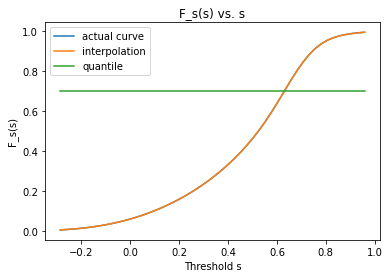

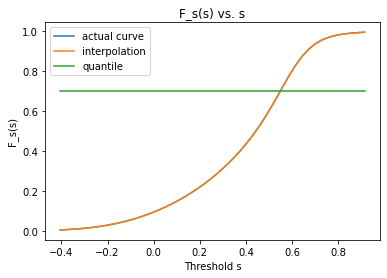

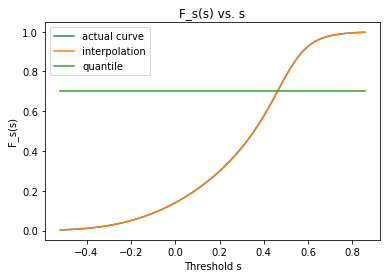

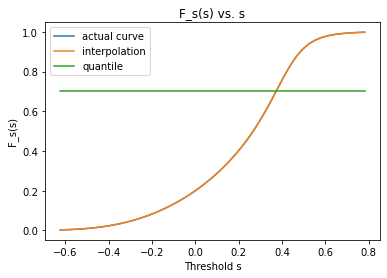

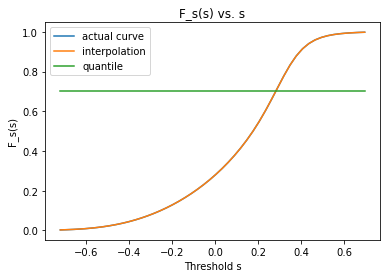

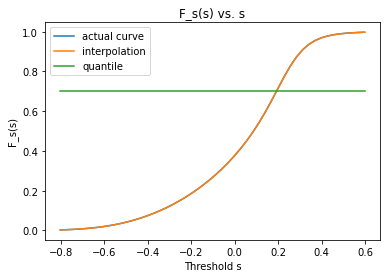

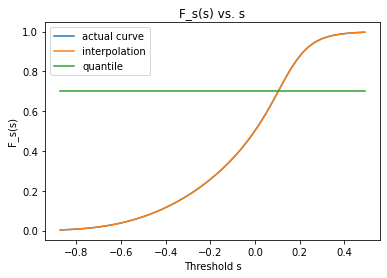

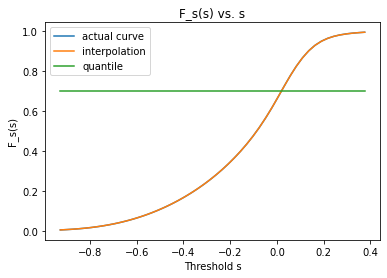

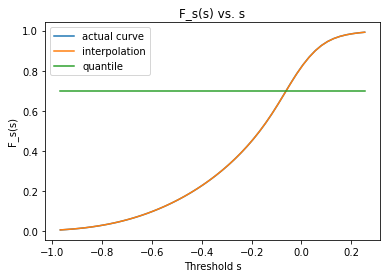

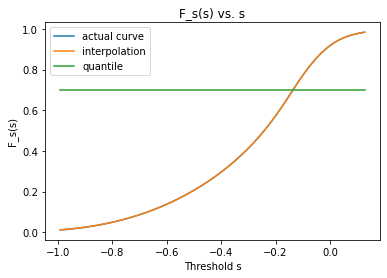

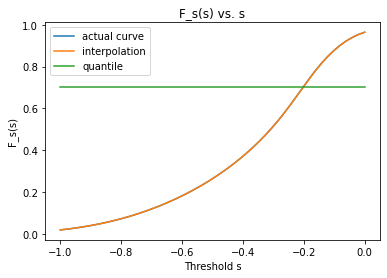

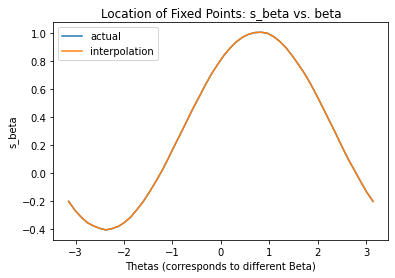

In [80]:
f = fixed_point_interpolation_true_distribution(agent_dist, sigma_contraction, q, plot=True, savefig="figs/fp_prisoners_dilemma.pdf")

[[0.8380881]
 [0.5455349]] 0.9942617581539783 -0.16162665050686076


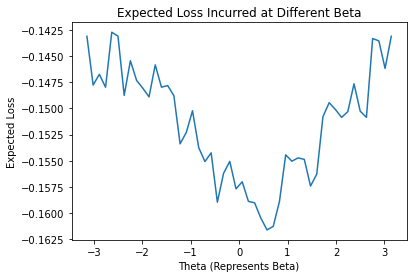

In [84]:
sigma_contraction = compute_contraction_noise(agent_dist)
thetas = np.linspace(-np.pi, np.pi, 200)

min_loss, beta_opt, s_beta, _, _ = optimal_beta_expected_policy_loss(agent_dist, sigma_contraction, f, plot=True, savefig="figs/loss_expected_prisoners_dilemma.pdf")
print(beta_opt, s_beta, min_loss)

[[0.98155916]
 [0.19115863]] 0.8957442383178416 -0.1586667720897878


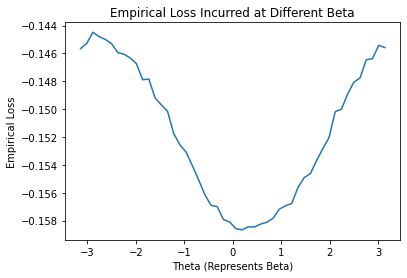

In [85]:
q = 0.7
min_loss, beta_opt, s_beta, _, _ = optimal_beta_empirical_policy_loss(agent_dist, sigma_contraction, q, f, plot=True, savefig="figs/loss_empirical_prisoners_dilemma.pdf")
print(beta_opt, s_beta, min_loss)

In [8]:
sigma_contraction = compute_contraction_noise(agent_dist)
thetas = np.linspace(-np.pi, np.pi, 200)

In [9]:
def policy_loss_mse(agent_dist, beta, s, sigma, true_beta=None):
    """Method that returns the policy loss incurred given an agent distribution and model and threshold.
    Assumes that there is an model true_beta when applied to the agents' hidden eta features 
    optimally selects the top agents.
    
    Keyword args:
    agent_dist -- AgentDistribution
    beta -- model parameters (N, 1) array
    s -- threshold (float)
    sigma -- standard deviation of the noise (float)
    true_beta -- (N, 1) array
    """
    if true_beta is None:
        true_beta = np.zeros(beta.shape)
        true_beta[0] = 1.
  

    true_agent_types = agent_dist.n_agent_types
    n_avg = 20
    etas = agent_dist.get_etas()
    losses = []
    
    br_dist = agent_dist.best_response_score_distribution(beta, s, sigma)
    n_br = br_dist[agent_dist.n_agent_types]
    curr_bounds = compute_score_bounds(beta)
    true_bounds = compute_score_bounds(true_beta)
    
        #since noise is independent given agent type, we can compute expectation over the noise
        
    noisy_scores = norm.rvs(loc=0.0, scale=sigma, size=agent_dist.n)
    noisy_scores += n_br
    noisy_scores = np.clip(noisy_scores, a_min=curr_bounds[0], a_max=curr_bounds[1]).reshape(agent_dist.n, 1)
    
    #normalize
    noisy_scores = (noisy_scores - curr_bounds[0])/(curr_bounds[1] - curr_bounds[0])
    
    etas = agent_dist.get_etas()
    ideal_scores = np.array([np.matmul(true_beta.T, eta).item() for eta in etas]).reshape(agent_dist.n, 1)
    ideal_scores = (ideal_scores - true_bounds[0])/(true_bounds[1] - true_bounds[0])
    
    loss = np.mean((ideal_scores - noisy_scores)**2)

    return loss

In [10]:
def policy_loss_expectation(agent_dist, beta, s, sigma, true_beta=None):
    """Method that returns the expected policy loss incurred given an agent distribution and model and threshold.
    Assumes that there is an model true_beta when applied to the agents' hidden eta features 
    optimally selects the top agents.
    
    Keyword args:
    agent_dist -- AgentDistribution
    beta -- model parameters (N, 1) array
    s -- threshold (float)
    sigma -- standard deviation of the noise (float)
    true_beta -- (N, 1) array
    """
    if true_beta is None:
        true_beta = np.zeros(beta.shape)
        true_beta[0] = 1.
    
    true_scores = np.array([np.matmul(true_beta.T, agent.eta).item() for agent in agent_dist.agents])
    br_dist = agent_dist.best_response_score_distribution(beta, s, sigma)
    z = s - br_dist
    prob = 1 - norm.cdf(x=z, loc=0., scale=sigma)
    plt.hist(prob)
    product = np.multiply(np.multiply(true_scores, prob), agent_dist.prop)
    res = np.sum(product)
        
    return -res

    
def find_all_fixed_points(agent_dist, sigma, q, plot=False, savefig=None):
    dim = agent_dist.d
    assert dim==2, "Method does not work for dimension {}".format(dim)
    
    thetas = np.linspace(0, 2 * np.pi, 50)
    fixed_points = []
    betas = []
    
    #compute beta and fixed point for each theta
    print("Computing fixed points...")
    for theta in thetas:
        beta = np.array([np.cos(theta), np.sin(theta)]).reshape(dim, 1)
        fp = agent_dist.quantile_fixed_point_naive(beta, sigma, q, plot=True)
        fixed_points.append(fp)
        betas.append(beta)
    
    if plot:
        plt.plot(thetas, fixed_points)
        plt.xlabel("Thetas (corresponds to different Beta)")
        plt.ylabel("s_beta")
        plt.title("Location of Fixed Points: s_beta vs. beta")
        if savefig is not None:
            plt.savefig(savefig)
        plt.show()
        plt.close()
        
    return betas, fixed_points

def find_optimal_beta_expectation(agent_dist, sigma, betas, fixed_points, plot=False, savefig=None):
    """Method that returns the model parameters that minimize the expected policy loss
    
    Method assumes that data is two dimensional (because model parameters are assumed to lie on unit circle.)
    
    Keyword args:
    agent_dist -- AgentDistribution
    q -- quantile of interest
    
    Returns:
    opt_beta -- optimal model (N, 1) array
    opt_s_beta -- fixed point corresponding to optimal model (float)
    loss -- loss incurred at optimal beta (float)
    """ 
    #compute loss at each point, given a particular beta
    dim = agent_dist.d
    assert dim==2, "Method does not work for dimension {}".format(dim)
    
    thetas = np.linspace(0, 2 * np.pi, 50)
    print("Computing losses...")
    losses = []
    for i in range(len(thetas)):
        loss = policy_loss_expectation(agent_dist, betas[i], fixed_points[i], sigma)
        losses.append(loss)
        
    if plot:
        plt.plot(thetas, losses)
        plt.xlabel("Theta (corresponds to different beta)")
        plt.ylabel("Loss")
        plt.title("Loss at (beta, s_beta)")
        if savefig is not None:
            plt.savefig(savefig)
        plt.show()
        plt.close()
        
    idx = np.argmin(losses)
    loss = losses[idx]
    opt_beta = betas[idx]
    opt_s_beta = fixed_points[idx]
    return loss, opt_beta, opt_s_beta 
    
def find_optimal_beta_empirical(agent_dist, sigma, q, betas, fixed_points, plot=False, savefig=None):
    """Method that returns the model parameters that minimize the empirical policy loss.
    
    Method assumes that data is two dimensional (because model parameters are assumed to lie on unit circle.)
    
    Keyword args:
    agent_dist -- AgentDistribution
    q -- quantile of interest
    
    Returns:
    opt_beta -- optimal model (N, 1) array
    opt_s_beta -- fixed point corresponding to optimal model (float)
    loss -- loss incurred at optimal beta (float)
    """ 
    #compute loss at each point, given a particular beta
    dim = agent_dist.d
    assert dim==2, "Method does not work for dimension {}".format(dim)
    
    thetas = np.linspace(0, 2 * np.pi, 50)
    print("Computing losses...")
    losses = []
    for i in range(len(thetas)):
        agent_dist.resample()
        loss = policy_loss_indicator(agent_dist, betas[i], fixed_points[i], sigma, q)
        losses.append(loss)
        
    if plot:
        plt.plot(thetas, losses)
        plt.xlabel("Theta (corresponds to different beta)")
        plt.ylabel("Loss")
        plt.title("Loss at (beta, s_beta)")
        if savefig is not None:
            plt.savefig(savefig)
        plt.show()
        plt.close()
        
    idx = np.argmin(losses)
    loss = losses[idx]
    opt_beta = betas[idx]
    opt_s_beta = fixed_points[idx]
    return loss, opt_beta, opt_s_beta  